In [1]:
import time
import os
import numpy as np
import random

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import plot_histogram

from quantuminspire.credentials import get_authentication
from quantuminspire.qiskit import QI

QI_URL = os.getenv('API_URL', 'https://api.quantum-inspire.com/')

In [3]:
authentication = get_authentication()
QI.set_authentication(authentication, QI_URL)

Enter email:
j.lizarraga@student.tudelft.nl
Enter password
········


In [48]:
def IntrinsicQuantumBB84Circuit():
   
    """
    Circuit Generator
    
    For Starmon5 purposes only
    """
    q = QuantumRegister(5)
    ans = ClassicalRegister(4)
    qc = QuantumCircuit(q, ans)
    
    qc.h(q[0])
    qc.h(q[1])
    qc.h(q[3])
    qc.measure(q[0],ans[0])
    qc.measure(q[1],ans[1])
    qc.measure(q[3],ans[2])
    
    qc.cx(q[0],q[2])
    qc.ch(q[1],q[2])
    qc.ch(q[3],q[2])

    qc.measure(q[2],ans[3])
    qc.draw()
    
    return q, qc

In [49]:
quantumResults, quantumCircuit = IntrinsicQuantumBB84Circuit()
qi_backend = QI.get_backend('QX-34-L')


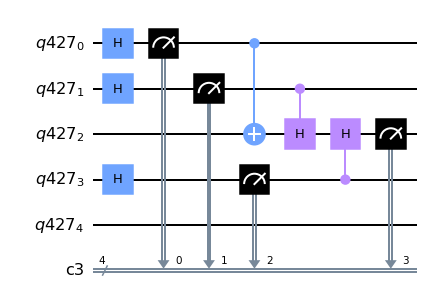

In [50]:
quantumCircuit.draw(output='mpl')

In [59]:
def BB84ProtocolQuantumRandom(messageLength):
    """
    Given the initial message length (int) it returns
    messageInABottle: randomly generated message to be communicated (A->B)
    AliceBasis: randomly generated Alice Basis (0:Z, 1:X)
    BobBasis: randomly generated Bob Basis (0:Z, 1:X)
    OutputString: either the result from the BB84 protocol if A&B have the same basis
    or an "x" if Basis(A) != Basis(B)! for each bit
    """
    
    
    n = 0
    messageInABottle = []
    AliceBasis = []
    BobBasis = []
    outputString = []
    sameBasisPositions = []
    
    while n < messageLength:
        job = execute(quantumCircuit, qi_backend,shots=1,memory=True)
        result = job.result()
        counts = result.get_counts()
        measure = list(counts.keys())

        messageInABottle.append(int(measure[0][0]))
        AliceBasis.append(int(measure[0][1]))
        BobBasis.append(int(measure[0][2]))
        
        if AliceBasis[n] == BobBasis[n]:
            outputString.append(int(measure[0][3]))
            sameBasisPositions.append(n)
        else:
            outputString.append("x")
        
        n = n+1
    

    return messageInABottle, AliceBasis, BobBasis, outputString, sameBasisPositions



In [63]:
def BB84ProtocolQuantumRandomFast(messageLength):
    """
    Given the initial message length (int) it returns
    messageInABottle: randomly generated message to be communicated (A->B)
    AliceBasis: randomly generated Alice Basis (0:Z, 1:X)
    BobBasis: randomly generated Bob Basis (0:Z, 1:X)
    OutputString: either the result from the BB84 protocol if A&B have the same basis
    or an "x" if Basis(A) != Basis(B)! for each bit
    """
    
    
    n = 0
    messageInABottle = []
    AliceBasis = []
    BobBasis = []
    outputString = []
    sameBasisPositions = []
    

    job = execute(quantumCircuit, qi_backend,shots=messageLength,memory=True)
    result = job.result()
    counts = result.get_counts()
    measure = result.get_memory()
    
    for n in range(messageLength):

        messageInABottle.append(int(measure[n][0]))
        AliceBasis.append(int(measure[n][1]))
        BobBasis.append(int(measure[n][2]))
        
        if AliceBasis[n] == BobBasis[n]:
            outputString.append(int(measure[n][3]))
            sameBasisPositions.append(n)
        else:
            outputString.append("x")
    

    return messageInABottle, AliceBasis, BobBasis, outputString, sameBasisPositions



In [64]:
messageLength = 10
prop = 0.5
tolerance = 0.8



messageInABottle, AliceBasis, BobBasis, messageOutput, goodIndices = BB84ProtocolQuantumRandomFast(messageLength)

print("Message:        ", messageInABottle)
print("Alice Basis:    ", AliceBasis)
print("Bob Basis:      ", BobBasis)
print("Output Message: ", messageOutput)

Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.


Message:         [0, 1, 1, 1, 0, 1, 1, 0, 1, 1]
Alice Basis:     [0, 0, 1, 1, 0, 1, 1, 0, 1, 0]
Bob Basis:       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
Output Message:  ['x', 'x', 1, 1, 'x', 1, 1, 'x', 1, 1]


In [52]:
def BB84KeyConstruction(message,output,goodIndices,prop,tolerance):
    """
    message: Alice starting message
    output: Bob's result through Quantum Magic
    goodIndices: bit Positions in which both basis are the same    
    prop: Proportion of common good bits to be compared
    tolerance: minimum success rate to generate a safe QK

    """
    auxList = []    
    nGoodBits = len(goodIndices)
    
    
    nComparingBits = int(nGoodBits*prop)
    comparingBitPositions = random.sample(goodIndices, nComparingBits)
    print("Bit Positions to compare: ",comparingBitPositions)
    
    allOkCounter = 0
    for i in range(nComparingBits):
        j = comparingBitPositions[i]
        if int(message[j])== int(output[j]):
            allOkCounter +=1
            
    for i in range(nGoodBits):
        if i not in comparingBitPositions:
            auxList.append(output[goodIndices[i]])
    
    #print(allOkCounter)
    successRate = float(allOkCounter/nComparingBits)
    print("Success rate: ",successRate)
    if successRate < tolerance:
        print("Failure")
        return 0
    else:
        print("Success!!!")
        return auxList

In [66]:
messageLength = 1000
prop = 0.5
tolerance = 0.8



messageInABottle, AliceBasis, BobBasis, messageOutput, goodIndices = BB84ProtocolQuantumRandomFast(messageLength)

print("Message:        ", messageInABottle)
print("Alice Basis:    ", AliceBasis)
print("Bob Basis:      ", BobBasis)
print("Output Message: ", messageOutput)

QKD = BB84KeyConstruction(messageInABottle,messageOutput,goodIndices,prop,tolerance)
print("QKD:            ",QKD)


Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.


Message:         [1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0